## Self-consistent denoiser with stochastic interpolants

### Set-up:
We are given corrupted data $x_0+\epsilon z$ where $x_0\sim \mu$ are samples from a distribution we wish to recover, $z\sim N(0,I)$ with $z\perp x_0$, and $\epsilon >0$ controls the level of the noise added. 

If we had the clean samples, we could do so with the framework of stochastic interpolants by defining

$$ I_t = t x_0 + (1-t) (x_0+\epsilon z) = x_0 + \epsilon t z $$

and learning a probability flow ODE with drift

$$ b_t(x) = \mathbb{E}[\dot I_t | I_t=x] = \mathbb{E}[\epsilon z | x_0 + \epsilon t z=x]$$

This drift is also given by

$$ b_t(x) = \mathop{\text{arg min }}_{\hat b} \mathbb{E}\int_0^1 \big|\hat b_t(I_t)- \dot I_t\big|^2 dt = \mathop{\text{arg min }}_{\hat b}\mathbb{E}\int_0^1 \big|\hat b_t(x_0 + \epsilon t z)- \epsilon z\big|^2 dt $$

The solutions of the probability flow ODE have the property that $X_{t=0}$ are clean samples from $\mu$ if $X_{t=1}$ are corrupted samples. *Note that the interpolant above uses coupled samples (same $x_0$ at both the clean and corrupted ends).*

### Learning the coupling self-consistently:
Since we do not have access to the samples $x_0$, here we will instead use $X_{t=0}$ as surrogate, i.e. we will solve the optimization problem

$$ \min_{\hat b} \mathbb{E}\int_0^1 \big|\hat b_t(X_{t=0} + \epsilon t z)- \epsilon  z\big|^2 dt $$

where $X_{t=0}$ is the solution at $t=0$ of the probability flow ODE solved backward in time from a corrupted sample $x_1$

$$\dot X_t = \hat b_t(X_t), \qquad X_{t=1} = x_1$$

In practice in the loss we detach $X_{t=0}$ from the gradient. The scheme implemented below does:

- generate data $X_{t=0}$ by solving the probability flow ODE backward in time using the current $\hat b_t(x)$;
- use these data to evaluate the loss and its gradient by detaching $X_{t=0}$ from this calculation;
- take a step of SDG to update $\hat b_t(x)$;
- repeat.

Note that the procedure learns a coupling between the clean data generated by solving the probbaility flow ODE and the corrupted data used as input. 

### Using a diffusion instead of the prob flow ODE:
Once we have learned the drift we also have access to the score of the distribution of $I_t$, given by

$$s_t(x) = - \frac1{\epsilon t} \mathbb{E}[z | x_0 + \epsilon t z=x] = -\frac1{\epsilon^2t} b_t(x)$$

Choosing as diffusion coefficient $D_t = \alpha \epsilon^2t $ with $\alpha\ge0$ to avoid singularity, this allows us to use the backward SDE

$$ dX_t = b_t(X_t) dt - D_t s_t(X_t) dt + \sqrt{2D_t} dW_t = (1+\alpha) b_t(X_t)dt + \sqrt{2a\epsilon^2 t} dW_t$$



### Generalization:
We could assume that the corruption is a random model $f(x_0)$, with $x_0\sim \mu$, and only access to data $x_1 = f(x_0)$. In this case, if we assume that $x_0$ and $f(x_0)$ live in the same space, the interpolant is

$$ I_t = t x_0 + (1-t) f(x_0)$$

and the drift solve

$$ \min_{\hat b} \mathbb{E} \int_0^1 \big|\hat b_t(I_t) - \dot I_t\big|^2 dt = \min_{\hat b} \mathbb{E} \int_0^1 \big|\hat b_t(t x_0 + (1-t) f(x_0)) - f(x_0)+x_0\big|^2 dt $$

Since we do not have access to the data $x_0\sim \mu$, we solve instead

$$ \min_{\hat b} \mathbb{E} \int_0^1 \big|\hat b_t(t X_{t=0} + (1-t) f(X_{t=0})) - f(X_{t=0})+X_{t=0}\big|^2 dt $$

where $X_t$ is again the solution at $t=0$ of the probability flow ODE solved backward in time from a corrupted sample $x_1$:

$$\dot X_t = \hat b_t(X_t), \qquad X_{t=1} = x_1$$

This reduces to the previous case if $f(x_0) = x_0 + \epsilon z$ with $z\sim N(0,I)$, $z\perp x_0$, and $\epsilon >0$.

### Software pre-requisites

In [1]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch  # 2.0 or greater
    from torch.func import vmap
    from torch.func import jacfwd
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

    
from typing import Callable
import math

All packages are installed!


In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(torch.backends.mps.is_available())
# device = 'cpu'

True


In [3]:
def grab(var):
    return var.detach().cpu().numpy()

### Defining and sampling the clean distributions

Choose between 3 distributions: a checker, a GMM, or the two moons


In [4]:
import torch
from torch.distributions import MultivariateNormal

class BaseDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean, cov)
    
    def sample(self, n=1):
        """
        Draws $n$ samples from the Gaussian distribution.   
        """
        return self.distribution.sample((n,))
    
    def log_prob(self, x):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)

mean = torch.tensor([0.0, 0.0])  # \mu \in R^2
cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # \Sigma \in R^{2x2}

base = BaseDistribution(mean, cov)

In [5]:
# checker
ndim = 2
def checker(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

target = checker

In [28]:
# GMM
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from torch.distributions.multivariate_normal import  MultivariateNormal

class Prior(torch.nn.Module):
    """
    Abstract class for prior distributions of normalizing flows. The interface
    is similar to `torch.distributions.distribution.Distribution`, but batching
    is treated differently. Parameters passed to constructors are never batched,
    but are aware of the target (single) sample shape. The `forward` method then
    accepts just the batch size and produces a batch of samples of the known
    shape.
    """
    def forward(self, batch_size):
        raise NotImplementedError()
    def log_prob(self, x):
        raise NotImplementedError()
    def draw(self, batch_size):
        """Alias of `forward` to allow explicit calls."""
        return self.forward(batch_size)

   
class GMM(Prior):
    def __init__(self, loc=None, var=None, scale = 1.0, ndim = None, nmix= None, device='cpu', requires_grad=False):
        super().__init__()
        
        self.device = device
        self.scale = scale       ### only specify if loc is None
        def _compute_mu(ndim):
                return self.scale*torch.randn((1,ndim))
                        
        if loc is None:
            self.nmix = nmix
            self.ndim = ndim 
            loc = torch.cat([_compute_mu(ndim) for i in range(1, self.nmix + 1)], dim=0)
            var = torch.stack([1.0*torch.ones((ndim,)) for i in range(nmix)])
        else:
            self.nmix = loc.shape[0]
            self.ndim = loc.shape[1] ### locs should have shape [n_mix, ndim]
            
        self.loc = loc   ### locs should have shape [n_mix, ndim]
        self.var = var   ### should have shape [n_mix, ndim]
        
        if requires_grad:
            self.loc.requires_grad_()
            self.var.requires_grad_()
        
        mix = Categorical(torch.ones(self.nmix,))
        comp = Independent(Normal(
                     self.loc, self.var), 1)
        self.dist = MixtureSameFamily(mix, comp)
        
    def log_prob(self, x):
        logp = self.dist.log_prob(x)
        return logp
    
    
    def forward(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x
    
    def rsample(self, batch_size):
        x = self.dist.rsample((batch_size,))
        return x
    
nmix = 8
ndim = 2
def _compute_mu(i):
            return 5.0 * torch.Tensor([[
                        torch.tensor(i * math.pi / 4).sin(),
                        torch.tensor(i * math.pi / 4).cos()]])
mus_target = torch.stack([_compute_mu(i) for i in range(nmix)]).squeeze(1)
var_target = torch.stack([torch.tensor([0.7, 0.7]) for i in range(nmix)])


target = GMM(mus_target, var_target)

In [25]:
# two moons
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
from sklearn.datasets import make_moons
class MoonDistribution(torch.nn.Module):
    def __init__(self, noise=0.1, shuffle=True, random_state=None, device='cpu'):
        super().__init__()
        
        self.device = device
        self.noise = noise
        self.shuffle = shuffle
        self.random_state = random_state
        
    def forward(self, n_samples):
        # Generate moon-shaped data with the specified number of samples
        X_moon, _ = make_moons(n_samples=n_samples, 
                              noise=self.noise, 
                              shuffle=self.shuffle, 
                              random_state=self.random_state)
        
        # Convert to torch tensor with float32
        return 4.0*(torch.tensor(X_moon, dtype=torch.float32).to(self.device)-0.5)
    
    def log_prob(self, x):
        # For simplicity, we can use a KDE approximation or leave unimplemented
        # if not needed for your application
        raise NotImplementedError("Log probability not implemented for this distribution")

# Create the moon distribution
target = MoonDistribution(noise=0.1, shuffle=True, random_state=None, device=device)

Below we can visualize both of the clean and the noisy distributions by drawing samples from them and plotting them

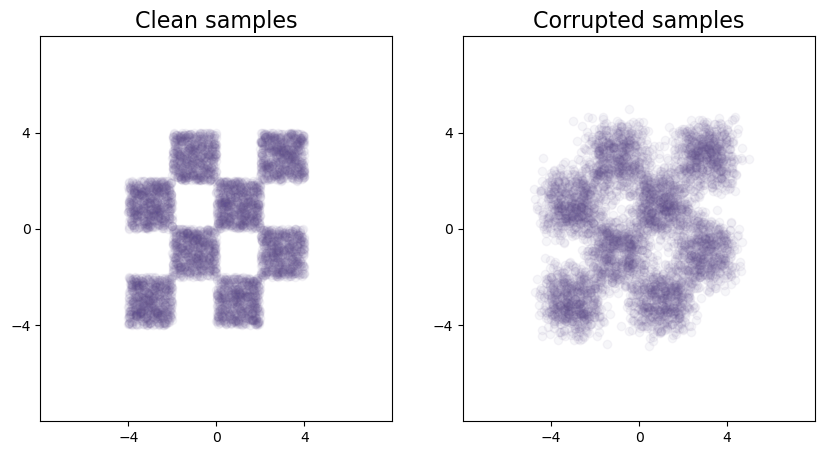

In [6]:
bs = 5000
c = '#62508f' # plot color

epsilon = torch.tensor(0.4)
x0s = target(bs).to('cpu').detach().numpy() 
x1s = x0s + (epsilon * base.sample(bs)).detach().numpy()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax0.scatter(x0s[:,0], x0s[:,1], alpha = 0.05, c = c)
ax0.set_xlim(-8,8), ax0.set_ylim(-8,8)
ax0.set_title(r"Clean samples", fontsize = 16)
ax0.set_xticks([-4,0,4]), ax0.set_yticks([-4,0,4])

ax1.scatter(x1s[:,0], x1s[:,1], alpha = 0.05, c = c)
ax1.set_xlim(-8,8), ax1.set_ylim(-8,8)
ax1.set_title(r"Corrupted samples", fontsize = 16)
ax1.set_xticks([-4,0,4]), ax1.set_yticks([-4,0,4]);

## Defining and learning $b_t(x)$

In [7]:
from torch.func import jacrev, grad

class VelocityField(torch.nn.Module):
    # a neural network that takes x in R^d and t in [0, 1] and outputs a a value in R^d
    def __init__(self, d,  hidden_sizes = [256, 256], activation=torch.nn.ReLU):
        super(VelocityField, self).__init__()
        
        layers = []
        prev_dim = d + 1  #
        for hidden_size in hidden_sizes:
            layers.append(torch.nn.Linear(prev_dim, hidden_size))
            layers.append(activation())
            prev_dim = hidden_size  # Update last_dim for the next layer

        # final layer
        layers.append(torch.nn.Linear(prev_dim, d))
        
        # Wrap all layers in a Sequential module
        self.net = torch.nn.Sequential(*layers)
    
    def _single_forward(self, x, t):  
        t = t.unsqueeze(-1)
        return self.net(torch.cat((x, t)))
    
    def forward(self, x, t):
        return vmap(self._single_forward, in_dims=(0,0), out_dims=(0))(x,t)

In [8]:
d = 2
b =  VelocityField(d, hidden_sizes=[128, 128, 128]).to(device)


bs = 10 ## simple test batch size
x = torch.rand(bs, d).to(device)
t = torch.rand(bs).to(device)

print(x.shape)
print(t.shape)

import time
tic = time.perf_counter()
out = b.forward(x,t) ## should output something of shape [bs, d]
toc = time.perf_counter()
print("time with mps:", toc-tic, " sec")

t = t.requires_grad_(True)
print(t.requires_grad)
print(out)

torch.Size([10, 2])
torch.Size([10])
time with mps: 0.2846770829928573  sec
True
tensor([[ 0.0940, -0.0769],
        [ 0.0990, -0.0819],
        [ 0.0832, -0.0902],
        [ 0.1039, -0.0779],
        [ 0.1053, -0.0787],
        [ 0.1074, -0.0793],
        [ 0.1006, -0.0819],
        [ 0.1177, -0.0812],
        [ 0.0995, -0.0764],
        [ 0.1003, -0.0894]], device='mps:0', grad_fn=<AddBackward0>)


In [9]:
def _single_loss(b, eps, z, x1, t):

    num_discretizations = 40
    delta_t = 1 / num_discretizations
    with torch.no_grad():
        Xt_prev = x1
        for i in range(1, num_discretizations+1):
            ti = torch.tensor(1 - (i-1) * delta_t).to(device)
            Xt_prev = Xt_prev - b._single_forward(Xt_prev, ti) * delta_t
        Xt_final = Xt_prev

    x0 = Xt_final

    It  = x0 + eps*t*z
    dIt = eps*z
   
    bt   = b._single_forward(It, t)
    loss = torch.sum((bt - dIt)**2)
    return loss


loss_fn = vmap(_single_loss, in_dims=(None, None, 0, 0, 0), out_dims=(0), randomness='different')

epsilon = torch.tensor(0.4)
N = 10
x0s = base.sample(N).to(device)
x1s = target(N).to(device) + epsilon*x0s
ts  = torch.rand(N).to(device)
loss_fn(b, epsilon, x0s, x1s, ts).mean()

# loss_fn = vmap(_single_loss, in_dims=(None, None, 0, 0, 0), out_dims=(0), randomness='different')

tensor(0.3656, device='mps:0', grad_fn=<MeanBackward0>)

In [10]:
lrb = 1e-3 ## learning rate
opt = torch.optim.Adam([
    {'params': b.parameters(), 'lr': lrb} ])
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=5000, gamma=0.9)

In [11]:
def train_step(b, opt, sched, N):
    
    ## draw N samples form each distribution and from time uniformly
    epsilon = torch.tensor(0.4).to(device)
    zs = base.sample(N).to(device)
    x1s = target(N).to(device) + epsilon*base.sample(N).to(device)
    ts  = torch.rand(N).to(device)
    
    # evaluate loss 
    loss_val = loss_fn(b, epsilon, zs, x1s, ts).mean()
    
    # perform backprop
    loss_val.backward()
    opt.step()
    sched.step()
    opt.zero_grad()
    
    res = {
            'loss': loss_val.detach().cpu(),
        }
    return res

In [12]:
n_opt = 100000
bs    = 2000

In [13]:
losses = []

In [28]:
from tqdm import tqdm
pbar = tqdm(range(n_opt))
for i in pbar:
    
    res = train_step(b, opt, sched, bs)
    loss = res['loss'].detach().numpy().mean()
    
    losses.append(loss)
    
    pbar.set_description(f'Loss: {loss:.4f}')  

Loss: 0.2692: 100%|██████████| 100000/100000 [1:56:26<00:00, 14.31it/s]    


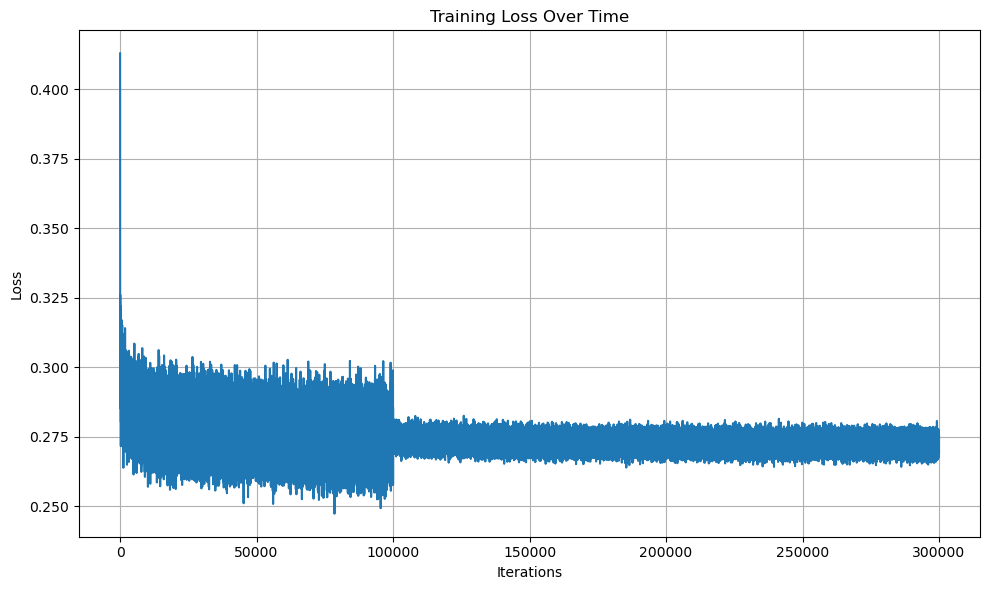

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(losses)
# Add labels and title
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Over Time')
# Add grid lines for better readability
ax.grid(True)
# Display the plot
plt.tight_layout()
plt.show()

## Integrating to prob flow ODE backward with the learned $b_t(x)$

In [30]:
class ODE:
    def __init__(self, b, n_step, rev = False):
        
        self.b           = b
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1).to(device)
        if rev == True:
            self.ts = torch.flip(self.ts, dims=[0])
        self.dt          = self.ts[1] - self.ts[0]   
    
    def step(self, x, t):
        return x + self.b(x, t)*self.dt 
    
    def solve(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape)).to(device)
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            t = t.repeat(len(x)).to(device)
            x = self.step(x,t)
            xs[i] = x
        return xs
    
    
ode  = ODE(b, n_step = 40, rev = True)

bs = 20000
epsilon = torch.tensor(0.4)
x_init = target(bs).to(device) + epsilon*base.sample(bs).to(device)
xfs    = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()

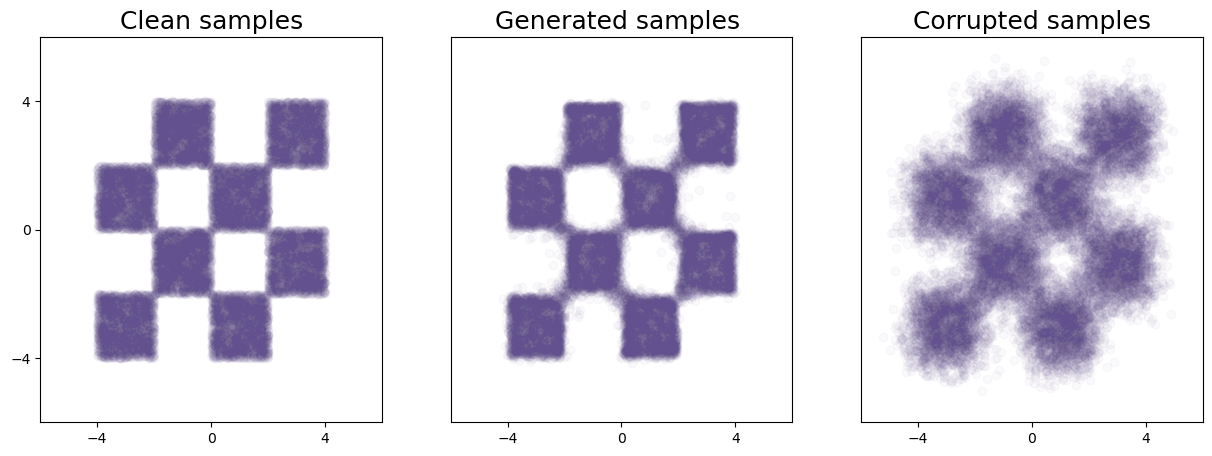

In [31]:
tt  = 1.0*torch.ones(bs)

x0se = target(bs)
x1se = target(bs) + epsilon*base.sample(bs)

c = '#62508f' # plot color
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(x0se[:,0], x0se[:,1], alpha = 0.03, c = c)
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xlim(-6,6), axes[0].set_ylim(-6,6)
axes[0].set_xticks([-4,0,4]), axes[0].set_yticks([-4,0,4]);

axes[1].scatter(x1s[:,0], x1s[:,1], alpha = 0.03, c = c)
axes[1].set_title(r"Generated samples ", fontsize = 18)
axes[1].set_xlim(-6,6), axes[1].set_ylim(-6,6)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].scatter(x1se[:,0], x1se[:,1], alpha = 0.03, c = c)
axes[2].set_title(r"Corrupted samples", fontsize = 18)
axes[2].set_xlim(-6,6), axes[2].set_ylim(-6,6)
axes[2].set_xticks([-4,0,4]), axes[2].set_yticks([]);

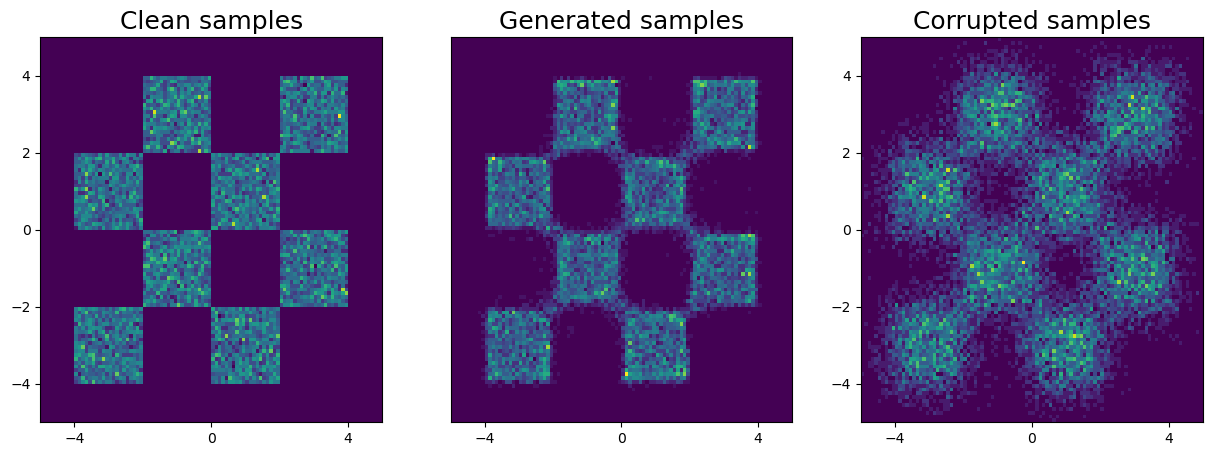

In [32]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].hist2d(x0se[:,0], x0se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[1].hist2d(x1s[:,0], x1s[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[1].set_title(r"Generated samples", fontsize = 18)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].hist2d(x1se[:,0], x1se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[2].set_title(r"Corrupted samples", fontsize = 18)
axes[2].set_xticks([-4,0,4]), axes[1].set_yticks([]);

## Integrating to SDE backward with the learned $b_t(x)$

In [33]:
class SDE:
    def __init__(self, b, alph, epsilon, n_step, rev = False):
        
        self.b           = b
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1).to(device)
        if rev == True:
            self.ts = torch.flip(self.ts, dims=[0])
        self.dt          = self.ts[1] - self.ts[0]  
        self.epsilon     = epsilon
        self.alph        = alph
        self.sqrtalphdt  = torch.sqrt(torch.tensor(2.0)*self.alph*self.epsilon**2*torch.abs(self.dt))
        self.device = device
    
    def step(self, x, t):
        return x + (1+self.alph)*self.b(x, t)*self.dt + self.sqrtalphdt*torch.sqrt(t.unsqueeze(-1))*torch.randn(x.size()).to(device)
    
    def solve(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape)).to(device)
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            t = t.repeat(len(x)).to(device)
            x = self.step(x,t)
            xs[i] = x
        return xs
    
    
sde  = SDE(b, alph = 1.0, epsilon = 0.4, n_step = 100, rev = True)

bs = 20000
eps = torch.tensor(0.4)
x_init = target(bs).to(device) + eps*base.sample(bs).to(device)
xfs_sde    = sde.solve(x_init)
x1s_sde = xfs_sde[-1].detach().cpu().numpy()

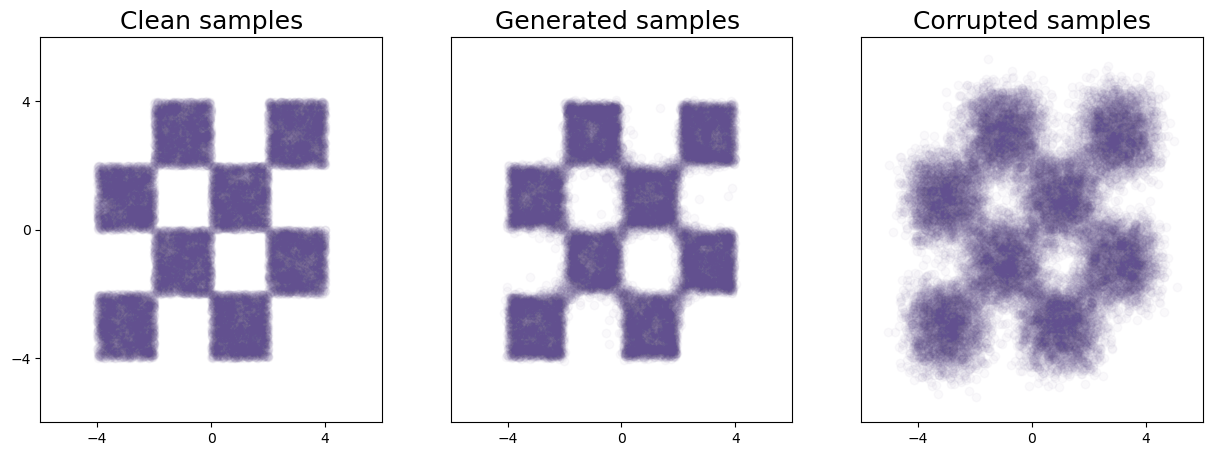

In [44]:
tt  = 1.0*torch.ones(bs)

x0se = target(bs)
x1se = target(bs) + eps*base.sample(bs)

c = '#62508f' # plot color
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(x0se[:,0], x0se[:,1], alpha = 0.03, c = c)
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xlim(-6,6), axes[0].set_ylim(-6,6)
axes[0].set_xticks([-4,0,4]), axes[0].set_yticks([-4,0,4]);

axes[1].scatter(x1s_sde[:,0], x1s_sde[:,1], alpha = 0.03, c = c)
axes[1].set_title(r"Generated samples ", fontsize = 18)
axes[1].set_xlim(-6,6), axes[1].set_ylim(-6,6)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].scatter(x1se[:,0], x1se[:,1], alpha = 0.03, c = c)
axes[2].set_title(r"Corrupted samples", fontsize = 18)
axes[2].set_xlim(-6,6), axes[2].set_ylim(-6,6)
axes[2].set_xticks([-4,0,4]), axes[2].set_yticks([]);

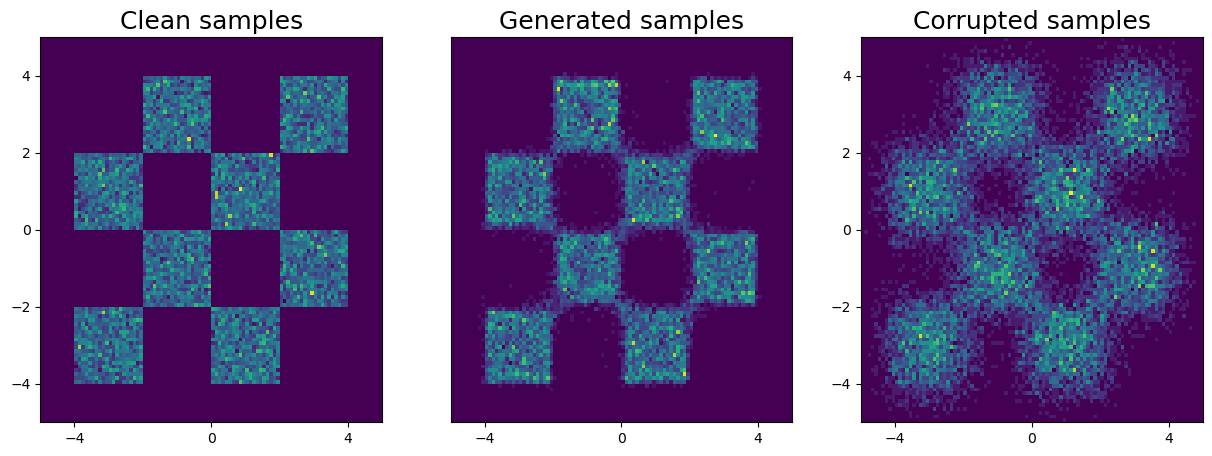

In [45]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].hist2d(x0se[:,0], x0se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[1].hist2d(x1s_sde[:,0], x1s_sde[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[1].set_title(r"Generated samples", fontsize = 18)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].hist2d(x1se[:,0], x1se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[2].set_title(r"Corrupted samples", fontsize = 18)
axes[2].set_xticks([-4,0,4]), axes[1].set_yticks([]);

### Baseline comparison: 
This solves the prob flow ODE using a single time step of size 1, which is equivalent to computing the conditional mean of $x_0$ given the noisy observation $x_0+\epsilon z$.

In [103]:
ode  = ODE(b, n_step = 1, rev = True)

bs = 20000
eps = torch.tensor(0.4)
x_init = target(bs).to(device) + eps*base.sample(bs).to(device)
xfs    = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()

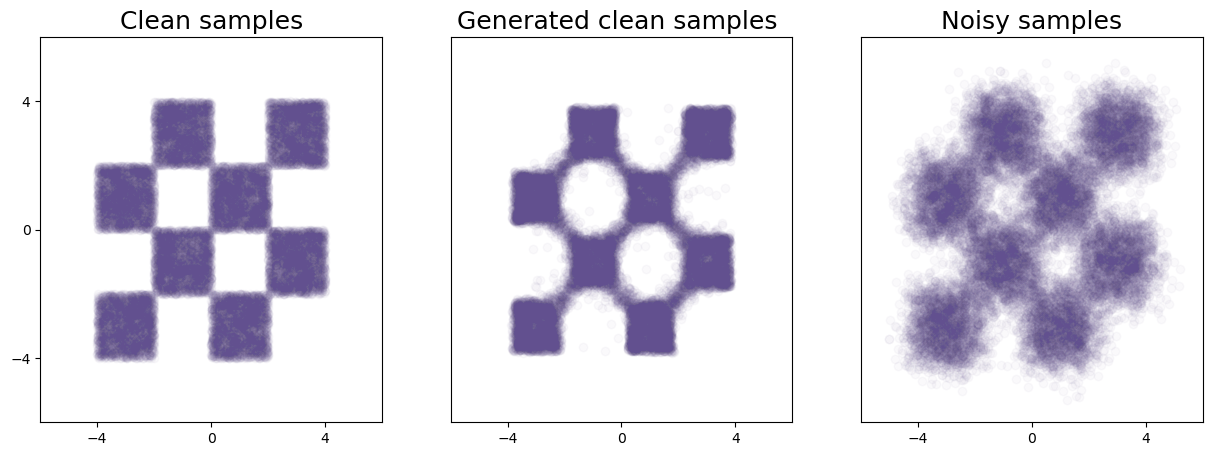

In [104]:
tt  = 1.0*torch.ones(20000)

x0se = target(20000)
x1se = target(20000) + eps*base.sample(20000)

c = '#62508f' # plot color
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(x0se[:,0], x0se[:,1], alpha = 0.03, c = c)
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xlim(-6,6), axes[0].set_ylim(-6,6)
axes[0].set_xticks([-4,0,4]), axes[0].set_yticks([-4,0,4]);

axes[1].scatter(x1s[:,0], x1s[:,1], alpha = 0.03, c = c)
axes[1].set_title(r"Generated clean samples ", fontsize = 18)
axes[1].set_xlim(-6,6), axes[1].set_ylim(-6,6)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].scatter(x1se[:,0], x1se[:,1], alpha = 0.03, c = c)
axes[2].set_title(r"Noisy samples", fontsize = 18)
axes[2].set_xlim(-6,6), axes[2].set_ylim(-6,6)
axes[2].set_xticks([-4,0,4]), axes[2].set_yticks([]);

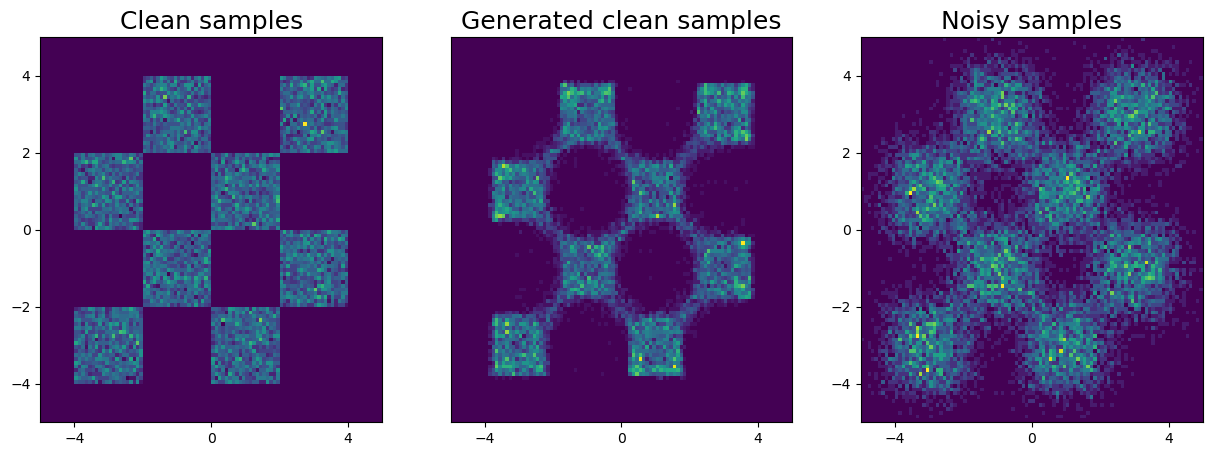

In [105]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].hist2d(x0se[:,0], x0se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[0].set_title(r"Clean samples", fontsize = 18)
axes[0].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[1].hist2d(x1s[:,0], x1s[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[1].set_title(r"Generated clean samples", fontsize = 18)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].hist2d(x1se[:,0], x1se[:,1], bins = 100, range=[[-5,5],[-5,5]])
axes[2].set_title(r"Noisy samples", fontsize = 18)
axes[2].set_xticks([-4,0,4]), axes[1].set_yticks([]);